In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time
from sklearn.metrics import f1_score

In [147]:
class NeuralNetwork:
    def __init__(self, layers, activation, last_layer_activation = None, optimisation=None, beta=0.9, rms_decay=0.9, weights_initialize=None):
        """
        :param layers: A list specifying the number of neurons in each layer.
        :param activation: The activation function to use in the hidden layers.
        :param last_layer_activation : Activation function to use for the last layer.
        :param weights_initialize: Type of weight initialization (e.g., He, Xavier). If None -> random from uniform distribution U([0,1])
        :param optimisation: Type of the optimizer to be used (momentum/RMS/None). 
        :param beta: Beta parameter for momentum optimiser
        :param rms_decay: decay parameter for RMSProp
        """

        self.layers = layers
        self.weights = []
        self.bias = []
        self.beta = beta
        self.rms_decay = rms_decay
        self.velocity_weights = []
        self.velocity_biases = []
        self.rms_weights = []
        self.rms_biases = []
        print('INIT INFO : ------------------------------------------------------------------------------------')
        # Validate optimization method
        if optimisation is None:
            print('No optimisation method')
            self.optimisation = None
        elif optimisation == 'momentum':
            print('Selected optimisation method: Momentum')
            self.optimisation = optimisation
        elif optimisation == 'rms':
            print('Selected optimisation method: RMSProp')
            self.optimisation = optimisation
        else:
            raise NameError("Chosen optimiser is not available, try 'momentum' or 'rms'")
   
        # Weight initialization
        for i in range(len(layers)-1):
            if weights_initialize == "Xavier":
                std = np.sqrt(2 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            elif weights_initialize == "He":
                std = np.sqrt(2 / layers[i])
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            else:
                self.weights.append(np.random.uniform(-0.5, 0.5, size=(layers[i], layers[i+1])))

            self.velocity_weights.append(np.zeros_like(self.weights[i]))
            self.velocity_biases.append(np.zeros_like(np.random.uniform(-0.5, 0.5, size=(layers[i+1],))))

        self.bias = [np.random.uniform(-0.5, 0.5, size=(layers[i+1],)) for i in range(len(layers)-1)]
        
        self.velocity_weights = [np.zeros_like(w) for w in self.weights]
        self.velocity_biases = [np.zeros_like(b) for b in self.bias]

        self.rms_weights = [np.zeros_like(w) for w in self.weights]
        self.rms_biases = [np.zeros_like(b) for b in self.bias]

        # Activation functions
        activation_functions = {
            "sigmoid": self.sigmoid,
            "tanh": self.tanh,
            "relu": self.relu,
            "leaky_relu": self.leaky_relu,
            "softmax": self.softmax
        }

        activation_functions_derivatives = {
            "sigmoid": self.sigmoid_derivative,
            "tanh": self.tanh_derivative,
            "relu": self.relu_derivative,
            "leaky_relu": self.leaky_relu_derivative,
            
        }

        self.activation_function = activation_functions.get(activation)
        self.activation_function_derivative = activation_functions_derivatives.get(activation)

        if last_layer_activation is None:
            print('Identity function chosen for last layer')
            self.last_layer_activation = None
        else:
            print(f'{last_layer_activation} function chosen for last layer.')
            self.last_layer_activation = activation_functions.get(last_layer_activation)

    # Activation functions
    def sigmoid(self, x): 
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x): 
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x): 
        return np.tanh(x)
    def tanh_derivative(self, x): 
        return 1 - self.tanh(x)**2

    def relu(self, x):
        return np.maximum(0, x)
    def relu_derivative(self, x):
        return (x > 0).astype(int)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)
    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def softmax(self, x):
        # Stable softmax to prevent overflow
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    
    def forward(self, X):
        self.a = [X]
        self.z = [X]
        for i in range(len(self.weights)-1):
            z = np.dot(self.a[-1], self.weights[i]) + self.bias[i]
            self.z.append(z)
            a = self.activation_function(z)
            self.a.append(a)

        z = np.dot(self.a[-1], self.weights[-1]) + self.bias[-1]
        self.z.append(z)
        # last layer activation
        if self.last_layer_activation is None:
            self.a.append(z)
        else:
            self.a.append(self.last_layer_activation(z))

        return self.a[-1]

    def backpropagate(self, X, y, learning_rate):
        m = X.shape[0]
        # For multiclass, we use cross-entropy loss with softmax
        delta = [self.a[-1] - y]
        # Backpropagate errors
        for i in range(len(self.weights)-1, 0, -1):
            error = np.dot(delta[-1], self.weights[i].T) * self.activation_function_derivative(self.z[i])
            delta.append(error)
        delta = delta[::-1]

        epsilon = 1e-9
        # Update weights according to chosen optimizer
        for i in range(len(self.weights)):
            grad_weights = np.dot(self.a[i].T, delta[i]) / m
            grad_bias = np.sum(delta[i], axis=0) / m

            if self.optimisation is None:
                self.weights[i] -= learning_rate * grad_weights
                self.bias[i] -= learning_rate * grad_bias

            elif self.optimisation == 'momentum':
                self.velocity_weights[i] = self.beta * self.velocity_weights[i] + learning_rate * grad_weights
                self.velocity_biases[i] = self.beta * self.velocity_biases[i] + learning_rate * grad_bias
                self.weights[i] -= self.velocity_weights[i]
                self.bias[i] -= self.velocity_biases[i]

            elif self.optimisation == 'rms':
                self.rms_weights[i] = self.rms_decay * self.rms_weights[i] + (1 - self.rms_decay) * grad_weights**2
                self.rms_biases[i] = self.rms_decay * self.rms_biases[i] + (1 - self.rms_decay) * grad_bias**2
                self.weights[i] -= learning_rate * grad_weights / (np.sqrt(self.rms_weights[i]) + epsilon)
                self.bias[i] -= learning_rate * grad_bias / (np.sqrt(self.rms_biases[i]) + epsilon)

    def train(self, X_train, y_train, X_test, y_test, learning_rate, epochs, loss_func, loss_threshold, batch_size=32,report_frequency = 100,  y_scaler = None, plot=True):
        train_scores = []
        test_scores = []
        num_samples = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward(X_batch)
                self.backpropagate(X_batch, y_batch, learning_rate)

            if loss_func == 'mse':
                train_loss = self.MSE(X_train, y_train)
                train_scores.append(train_loss)

            elif loss_func =='F1':
                train_loss = self.cross_entropy_loss(X_train, y_train) #cross entropy for training
                train_scores.append(train_loss)
            else:
                raise ValueError("No such metric implemented")

            # Evaluate every k epochs
            if epoch % report_frequency == 0:
                if loss_func == 'F1':
                    y_pred_proba = self.predict(X_test)
                    y_pred = np.argmax(y_pred_proba, axis=1) #converting to class label
                    y_true = np.argmax(y_test, axis=1)
                    f1 = f1_score(y_true, y_pred, average='weighted') #weightes f1 score
                    test_scores.append(f1) 

                    print(f"Epoch {epoch}, Training F1: {train_loss:.8f}, Test F1: {f1:.4f}")
                    if f1 >=loss_threshold:
                        print(f'F1 SCORE ACHIEVED : {f1} stopping at epoch {epoch}')
                        break

                elif loss_func=='mse':
                    Y_pred_denorm=y_scaler.inverse_transform(self.predict(X_test))
                    mse = np.mean((Y_pred_denorm - y_test) ** 2)
                    test_scores.append(mse)
                    print(f"Epoch {epoch}, Training MSE: {train_loss:.8f}, Test MSE: {mse:.4f}")
                    if mse < loss_threshold:
                        print(f'MSE ACHIEVED : {mse} stopping at epoch {epoch}')
                        break

                
        end_time = time.time()
        print('Training Duration:', end_time - start_time)

        # Plotting
        if plot:
            if len(train_scores) >3:
                plt.figure(figsize=(12, 5))
                
                plt.subplot(1, 2, 1)
                plt.plot(train_scores)
                plt.title('Training Scores')
                plt.xlabel('Epochs')
                if loss_func=='mse':
                    plt.ylabel('MSE')
                elif loss_func=="F1":
                    plt.ylabel('Cross Entropy Loss')
                
                plt.subplot(1, 2, 2)
                plt.plot(test_scores)
                plt.title('Test Scores')
                plt.xlabel(f'Epochs per ({report_frequency})')
                if loss_func=='mse':
                    plt.ylabel('MSE')
                elif loss_func=="F1":
                    plt.ylabel('Weighted F1')
                plt.tight_layout()
                plt.show()


    def predict(self, X):
        return self.forward(X)
    
    def cross_entropy_loss(self, X, Y):
        # Compute cross-entropy loss for multiclass classification
        y_pred = self.predict(X)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(Y * np.log(y_pred), axis=1))
    def MSE(self, X, Y):
        return np.mean((self.predict(X) - Y) ** 2)





## Rings

In [157]:
train_df = pd.read_csv('data/rings3-regular-training.csv')
test_df = pd.read_csv('data/rings3-regular-test.csv')

print(f"Number of classes: {train_df['c'].nunique()}")

Number of classes: 3


In [ ]:
X_train = train_df[['x', 'y']].to_numpy()
Y_train = train_df['c'].to_numpy().reshape(-1,1)  
X_test = test_df[['x', 'y']].to_numpy()
Y_test = test_df['c'].to_numpy().reshape(-1,1)  

# # Normalizacja X
# x_scaler = MinMaxScaler()
# X_train_normalized = x_scaler.fit_transform(X_train)
# X_test_normalized = x_scaler.transform(X_test)

# # Kodowanie one-hot dla Y
y_encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = y_encoder.fit_transform(Y_train)  
Y_test_encoded = y_encoder.transform(Y_test) 

print(Y_test_encoded.shape)

(2000, 3)


### Softmax activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.03418893, Test F1: 0.5230
Epoch 10, Training F1: 0.81551999, Test F1: 0.5950
Epoch 20, Training F1: 0.79530751, Test F1: 0.6505
Epoch 30, Training F1: 0.81279792, Test F1: 0.6051
Epoch 40, Training F1: 0.76762506, Test F1: 0.6190
Epoch 50, Training F1: 0.77366264, Test F1: 0.6261
Epoch 60, Training F1: 0.73329839, Test F1: 0.6351
Epoch 70, Training F1: 0.70077707, Test F1: 0.6837
Epoch 80, Training F1: 0.69507676, Test F1: 0.6616
Epoch 90, Training F1: 0.81381670, Test F1: 0.5745
Epoch 100, Training F1: 1.17507362, Test F1: 0.5493
Epoch 110, Training F1: 0.71075341, Test F1: 0.6723
Epoch 120, Training F1: 0.64629081, Test F1: 0.6870
Epoch 130, Training F1: 0.70027932, Test F1: 0.6166
Epoch 140, Training F1: 0.61103978, Test F1: 0.6577
Epoch 150, Training F1: 0.66979109, Test F1: 0.6921
Epoch 160, Training

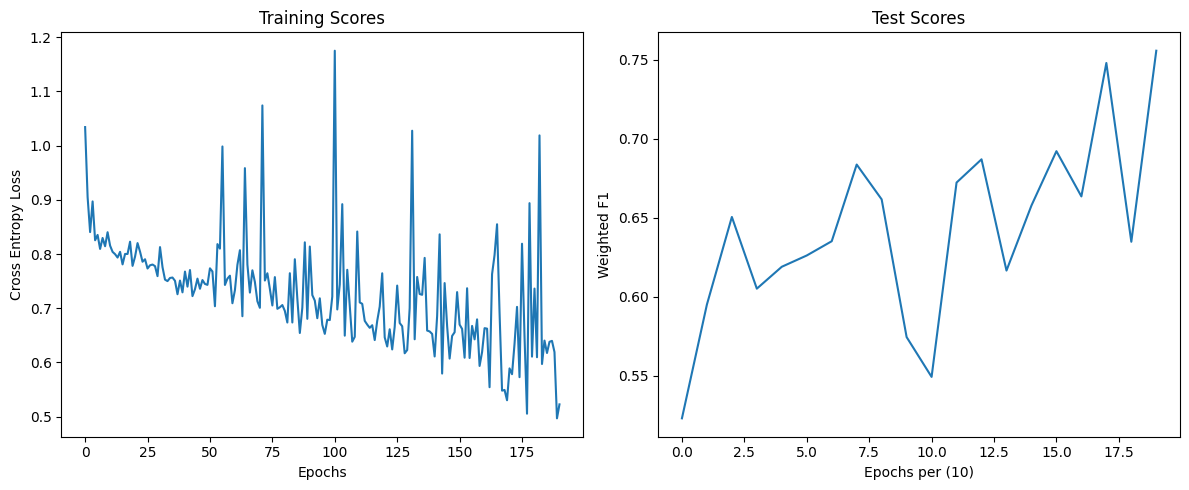

In [150]:
nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='softmax')
nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, report_frequency=10, loss_threshold=0.75)

## Sigmoid activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.99207160, Test F1: 0.3853
Epoch 20, Training F1: 0.99927881, Test F1: 0.5685
Epoch 40, Training F1: 0.97469782, Test F1: 0.5830
Epoch 60, Training F1: 0.95439549, Test F1: 0.5850
Epoch 80, Training F1: 0.93291853, Test F1: 0.5888
Epoch 100, Training F1: 0.90636209, Test F1: 0.5868
Epoch 120, Training F1: 0.87562675, Test F1: 0.5995
Epoch 140, Training F1: 0.85124616, Test F1: 0.6272
Epoch 160, Training F1: 0.85575474, Test F1: 0.5955
Epoch 180, Training F1: 0.79212310, Test F1: 0.6069
Epoch 200, Training F1: 0.76115972, Test F1: 0.6181
Epoch 220, Training F1: 0.76379159, Test F1: 0.6432
Epoch 240, Training F1: 0.77554077, Test F1: 0.5826
Epoch 260, Training F1: 0.75563675, Test F1: 0.6585
Epoch 280, Training F1: 0.69678771, Test F1: 0.6493
Epoch 300, Training F1: 0.71777543, Test F1: 0.6184
Epoch 320, Tra

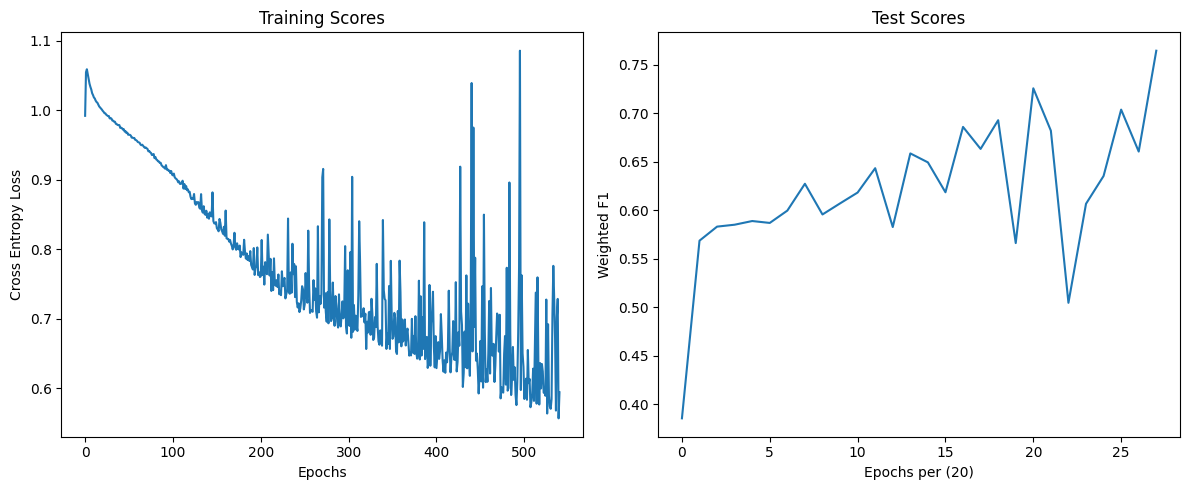

In [152]:
nn = NeuralNetwork(layers=[2, 64,32, 3], activation="sigmoid", last_layer_activation='sigmoid')
nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000,report_frequency=20, loss_threshold=0.75)

## Easy

In [158]:
train_df = pd.read_csv('data/easy-training.csv')
test_df = pd.read_csv('data/easy-test.csv')

print(f"Number of classes {train_df['c'].nunique()}")

Number of classes 2


In [159]:
X_train = train_df[['x', 'y']].to_numpy()
Y_train = train_df['c'].to_numpy().reshape(-1,1)  
X_test = test_df[['x', 'y']].to_numpy()
Y_test = test_df['c'].to_numpy().reshape(-1,1)  

# # Kodowanie one-hot dla Y
y_encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = y_encoder.fit_transform(Y_train)  
Y_test_encoded = y_encoder.transform(Y_test) 

print(Y_train_encoded.shape)

(500, 2)


## Softmax activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.12645748, Test F1: 0.9579
Epoch 20, Training F1: 0.03780214, Test F1: 0.9740
Epoch 40, Training F1: 0.03992580, Test F1: 0.9880
Epoch 60, Training F1: 0.03264907, Test F1: 0.9900
Epoch 80, Training F1: 0.02274794, Test F1: 0.9840
Epoch 100, Training F1: 0.01552863, Test F1: 0.9980
F1 SCORE ACHIEVED : 0.998000024000864 stopping at epoch 100
Training Duration: 0.09504127502441406


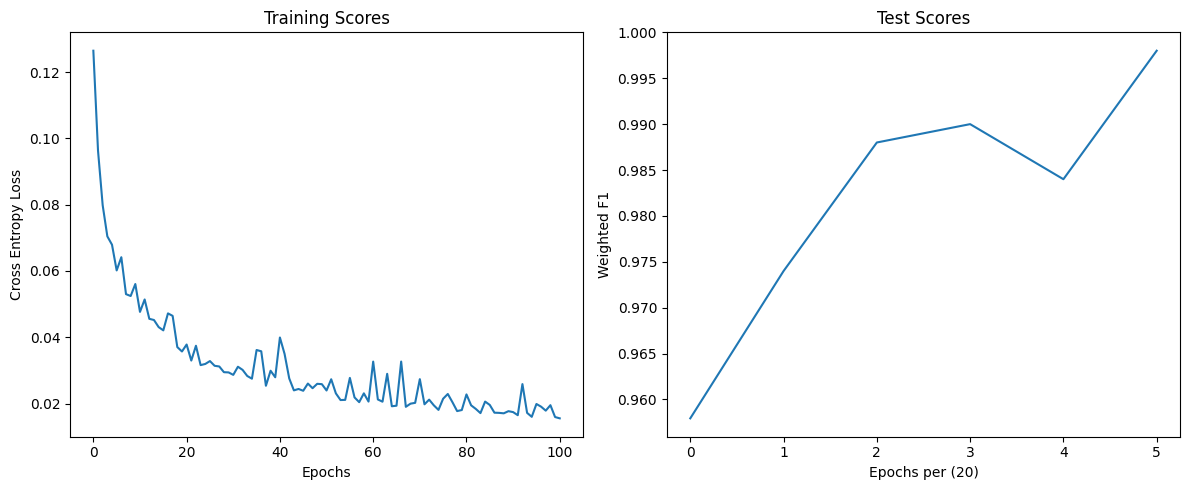

In [160]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="relu", last_layer_activation='softmax')
nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, report_frequency=20, loss_threshold=0.99)

## Tanh activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 0.69383430, Test F1: 0.9660
Epoch 10, Training F1: 0.23748684, Test F1: 0.9780
Epoch 20, Training F1: 0.12036841, Test F1: 0.9920
F1 SCORE ACHIEVED : 0.991998975737789 stopping at epoch 20
Training Duration: 0.027071475982666016


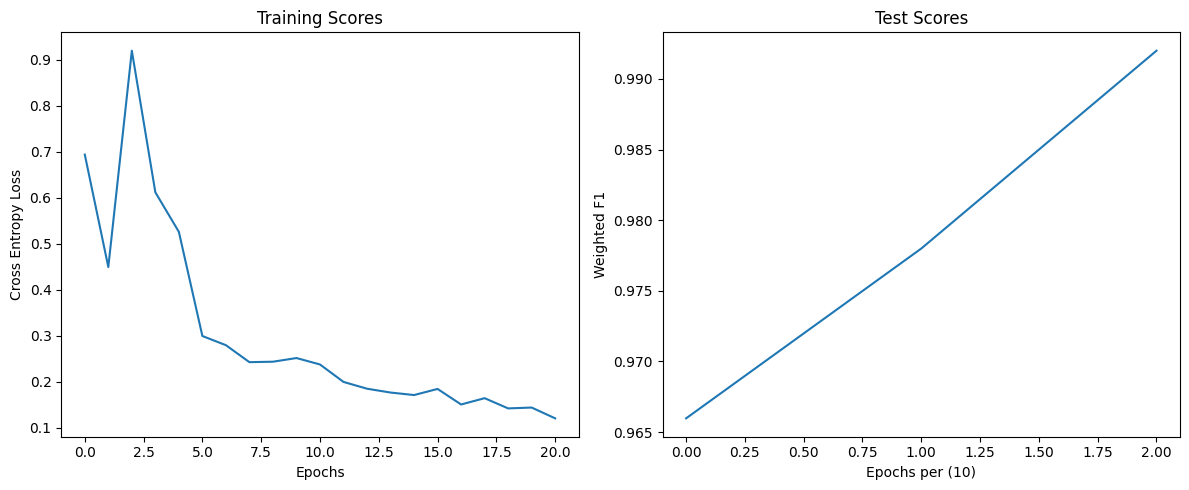

In [161]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='tanh')
nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Xor 3

In [162]:
train_df = pd.read_csv('data/xor3-training.csv')
test_df = pd.read_csv('data/xor3-test.csv')

train_df['c'].nunique()

2

In [163]:
X_train = train_df[['x', 'y']].to_numpy()
Y_train = train_df['c'].to_numpy().reshape(-1,1)  
X_test = test_df[['x', 'y']].to_numpy()
Y_test = test_df['c'].to_numpy().reshape(-1,1)  

# Normalizacja X
# x_scaler = MinMaxScaler()
# X_train_normalized = x_scaler.fit_transform(X_train)
# X_test_normalized = x_scaler.transform(X_test)

# # Kodowanie one-hot dla Y
y_encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = y_encoder.fit_transform(Y_train)  
Y_test_encoded = y_encoder.transform(Y_test) 

print(X_test.shape)

(500, 2)


## Softmax activation 

#### 1 : mse 94

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 5.90235155, Test F1: 0.5414
Epoch 100, Training F1: 0.25339164, Test F1: 0.8392
Epoch 200, Training F1: 0.25091761, Test F1: 0.8411
Epoch 300, Training F1: 0.28637312, Test F1: 0.8234
Epoch 400, Training F1: 0.25370202, Test F1: 0.8293
Epoch 500, Training F1: 0.25391756, Test F1: 0.8424
Epoch 600, Training F1: 0.24576925, Test F1: 0.8370
Epoch 700, Training F1: 0.25592899, Test F1: 0.8428
Epoch 800, Training F1: 0.24512757, Test F1: 0.8405
Epoch 900, Training F1: 0.24399147, Test F1: 0.8428
Epoch 1000, Training F1: 0.25137225, Test F1: 0.8449
Epoch 1100, Training F1: 0.25568806, Test F1: 0.7914
Epoch 1200, Training F1: 0.24098623, Test F1: 0.8292
Epoch 1300, Training F1: 0.25531782, Test F1: 0.8404
Epoch 1400, Training F1: 0.24455055, Test F1: 0.8174
Epoch 1500, Training F1: 0.23667159, Test F1: 0.8469
Epoc

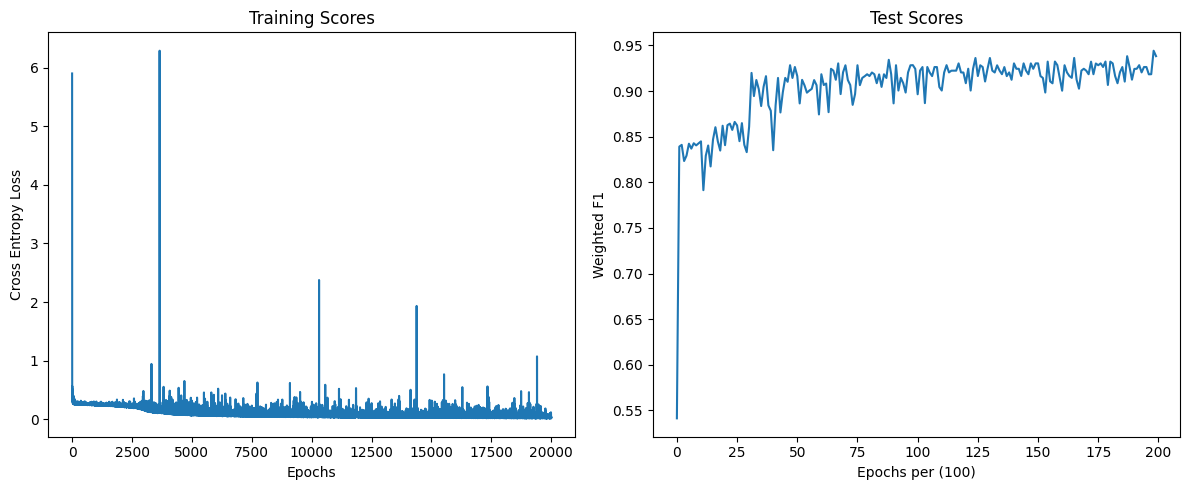

In [170]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='softmax')
nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01,batch_size=64, epochs=20000, loss_threshold=0.97)

### 2 mse:

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 3.11459363, Test F1: 0.7506
Epoch 100, Training F1: 0.25709220, Test F1: 0.8425
Epoch 200, Training F1: 0.24873672, Test F1: 0.8330
Epoch 300, Training F1: 0.25622146, Test F1: 0.8135
Epoch 400, Training F1: 0.24028957, Test F1: 0.8381
Epoch 500, Training F1: 0.24816182, Test F1: 0.8490
Epoch 600, Training F1: 0.22972673, Test F1: 0.8478
Epoch 700, Training F1: 0.22330689, Test F1: 0.8464
Epoch 800, Training F1: 0.21765636, Test F1: 0.8271
Epoch 900, Training F1: 0.22388241, Test F1: 0.8561
Epoch 1000, Training F1: 0.19840226, Test F1: 0.8544
Epoch 1100, Training F1: 0.23649064, Test F1: 0.8292
Epoch 1200, Training F1: 0.26263507, Test F1: 0.8230
Epoch 1300, Training F1: 0.20091372, Test F1: 0.8564
Epoch 1400, Training F1: 0.22619841, Test F1: 0.8486
Epoch 1500, Training F1: 0.27648344, Test F1: 0.8342
Epoc

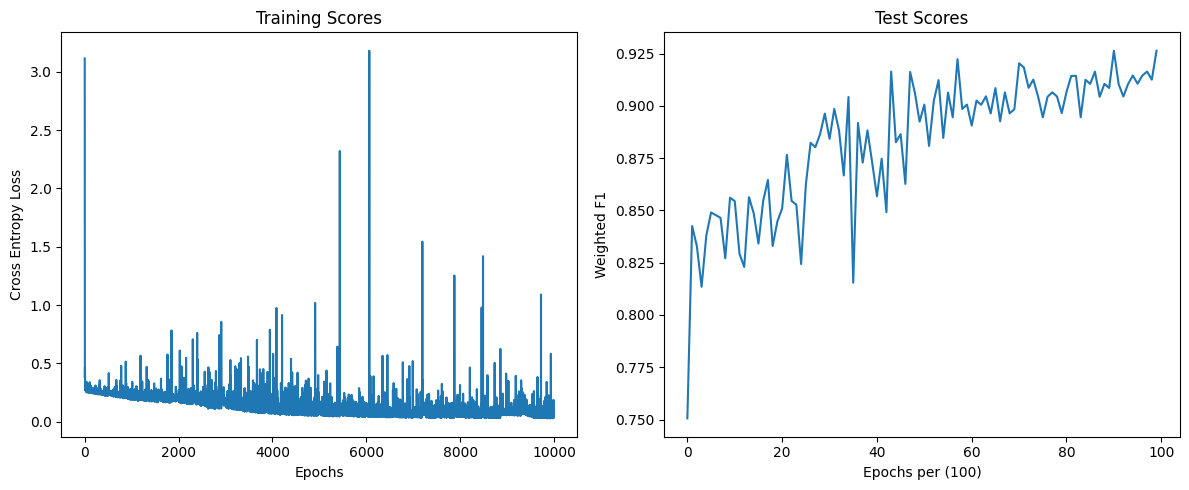

In [177]:
nn = NeuralNetwork(layers=[2, 64,64,32, 2], activation="relu", last_layer_activation='softmax')
nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=0.97)